# Cassava Leaf Disease Classifer - Resnet34 with FastAIv2

This notebook trains a pre-trained ResNet34 model to recognize diseases of cassava plants fromlabelled pictures of the leaves. There are  21,367 images in tre training data of four different diseases as well as healthy plants.

It is part of a [kaggle competition ](https://www.kaggle.com/c/cassava-leaf-disease-classification) and I am using it to get practice training models with FastAI v2

A quick-and-dirty approach of just splitting the training dataset into 80% train, 20% validation, resizing images to 128x128 and tuning for 4 epochs gives an error rate of 23%.

## Step 1: Read labels for the images and generate a function to apply labels

FastAI requires a function that applies a label to each image. For this dataset, labels are stored in a CSV alongside the filenames
I read all of the image labels into a {filename: label} dictionary, then generate a partial function that takes the full filepath of the image and returns the label

In [6]:
from pathlib import Path
import csv
from collections import defaultdict
from functools import partial

datadir = Path('../input/cassava-leaf-disease-classification/')
labels = defaultdict()

with open(datadir/'train.csv') as csvlabels:
    reader = csv.reader(csvlabels)
    for row in reader:
        labels[row[0]] = row[1]

def lookup_label(labels, fname):
    # fname will be a path, just want the filename
    return labels[fname.name]

label_func = partial(lookup_label, labels)

## Create a DataLoader to feed into my model

Now that I have my label function, I can create a DataBlock to load the image files

In [13]:
# Create our datablock and dataloader
from fastai.data.all import *
from fastai.vision.all import *

leaves = DataBlock(
    blocks = (ImageBlock, CategoryBlock),
    get_items = get_image_files,
    splitter = RandomSplitter(valid_pct = 0.2, seed=42),
    get_y = label_func,
    item_tfms = Resize(244)
)

leaves_test = DataBlock(
    
)

dls = leaves.dataloaders(datadir/'train_images')
dls.valid.show_batch(max_n=4, nrows=1)


RuntimeError: CUDA out of memory. Tried to allocate 352.00 MiB (GPU 0; 15.90 GiB total capacity; 14.36 GiB already allocated; 237.75 MiB free; 14.92 GiB reserved in total by PyTorch)

In [11]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(3)

RuntimeError: CUDA out of memory. Tried to allocate 236.00 MiB (GPU 0; 15.90 GiB total capacity; 14.36 GiB already allocated; 237.75 MiB free; 14.92 GiB reserved in total by PyTorch)

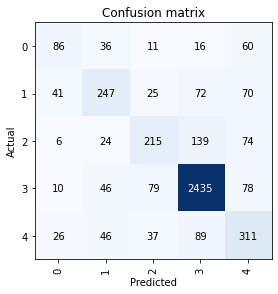

In [9]:
from fastai.interpret import ClassificationInterpretation

interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()